In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from sklearn.metrics import f1_score

# Dataset Brasileiro


In [ ]:
# Visualização do .csv desejado
leitor = pd.read_csv("libras_data.csv", dtype = int)
leitor

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0,236,236,234,234,234,234,234,234,234,...,209,214,219,223,228,232,234,236,239,241
1,0,255,255,255,255,255,255,255,255,214,...,100,249,254,255,255,255,255,248,185,149
2,0,255,255,255,255,255,255,255,255,223,...,115,253,253,255,255,255,254,247,185,154
3,0,236,236,236,236,236,236,236,236,236,...,201,210,214,220,226,230,233,236,239,240
4,0,255,255,255,255,255,255,255,255,193,...,81,90,76,165,66,77,122,253,238,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,21,179,179,179,180,180,181,181,181,182,...,180,180,180,180,180,180,180,180,179,179
2838,21,181,182,182,182,180,181,183,185,186,...,181,181,181,181,180,180,180,180,180,180
2839,21,179,180,180,181,181,181,180,182,182,...,180,180,180,180,180,180,181,181,181,181
2840,21,180,181,181,181,176,183,190,188,181,...,179,179,179,179,181,181,181,181,181,181


In [ ]:
# Classe para manipulação do dataset
class GestureDataset(Dataset):
    def __init__(self, csv, train=True):
        self.csv = pd.read_csv(csv)
        self.img_size = 224
        self.train = train

        num_images = self.csv.shape[0]
        self.images = torch.tensor(self.csv.iloc[:, 1:].values, dtype=torch.float32)
        self.images = self.images.reshape(num_images, 50, 50)

        self.labels = self.csv['0']
        print(self.labels)
        print(self.images.size())

        # Transforms para data augmentation
        self.train_transforms = transforms.Compose([
            transforms.ToPILImage(),  # Converte o tensor para imagem PIL
            transforms.Resize((self.img_size, self.img_size)),  # Redimensiona para img_size
            transforms.RandomRotation(10),  # Rotação aleatória de até 10 graus
            transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
            transforms.ColorJitter(brightness=0.01, contrast=0.2),  # Ajustes de brilho/contraste
            transforms.ToTensor(),  # Converte de volta para tensor
            transforms.Normalize((0.5,), (0.5,))  # Normalização
        ])

        # Transforms para teste/validação
        self.test_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __getitem__(self, index):
        img = self.images[index].numpy()

        if self.train:
            tensor_image = self.train_transforms(img)
        else:
            tensor_image = self.test_transforms(img)

        if self.train:
            return tensor_image, self.labels[index]
        else:
            return tensor_image

    def __len__(self):
        return self.images.shape[0]

In [ ]:
# Cria um objeto correspondente a cada dataset
libras_train = GestureDataset("train.csv")
libras_test = GestureDataset("test.csv")
libras_validation = GestureDataset("validation.csv")

0        0
1        0
2        0
3        0
4        0
        ..
1404    34
1405    34
1406    34
1407    34
1408    34
Name: 0, Length: 1409, dtype: int64
torch.Size([1409, 50, 50])
0       0
1       0
2       0
3       0
4       0
       ..
231    34
232    34
233    34
234    34
235    34
Name: 0, Length: 236, dtype: int64
torch.Size([236, 50, 50])
0       0
1       0
2       0
3       0
4       0
       ..
470    34
471    34
472    34
473    34
474    34
Name: 0, Length: 475, dtype: int64
torch.Size([475, 50, 50])


In [ ]:
train_loader=torch.utils.data.DataLoader(dataset=libras_train,batch_size=50,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=libras_test, batch_size=50, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=libras_validation, batch_size=50, shuffle=True)

In [ ]:
# Classe para a rede neural
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.Conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 5), # 220, 220
        nn.MaxPool2d(2), # 110, 110
        nn.ReLU(),
        nn.BatchNorm2d(32)
        )
        self.Conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 5), # 106, 106
        nn.MaxPool2d(2),  # 53,53
        nn.ReLU(),
        nn.BatchNorm2d(64)
        )
        self.Conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3), # 51, 51
        nn.MaxPool2d(2), # 25, 25
        nn.ReLU(),
        nn.BatchNorm2d(128)
        )
        self.Conv4 = nn.Sequential(
        nn.Conv2d(128, 256, 3), # 23, 23
        nn.MaxPool2d(2), # 11, 11
        nn.ReLU(),
        nn.BatchNorm2d(256)
        )
        self.Conv5 = nn.Sequential(
        nn.Conv2d(256, 512, 3), # 9, 9
        nn.MaxPool2d(2), # 4, 4
        nn.ReLU(),
        nn.BatchNorm2d(512)
        )

        self.Linear1 = nn.Linear(512 * 4 * 4, 256)
        self.dropout=nn.Dropout(0.3)
        self.Linear3 = nn.Linear(256, 35)

    def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x=self.dropout(x)
        x = self.Conv5(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.dropout(x)
        x = self.Linear3(x)
        return x

In [ ]:
# Utiliza F1-Score como métrica de validação do modelo
def validate(val_loader, model):
    model.eval()
    test_labels=[0]
    test_pred=[0]

    for i, (images,labels) in enumerate(val_loader):
        outputs=model(images.to(device))
        predicted = torch.softmax(outputs,dim=1)
        _,predicted=torch.max(predicted, 1)
        test_pred.extend(list(predicted.data.cpu().numpy()))
        test_labels.extend(list(labels.data.cpu().numpy()))

    test_pred=np.array(test_pred[1:])
    test_labels=np.array(test_labels[1:])
    correct=(test_pred==test_labels).sum()

    accuracy=correct/len(test_labels)
    f1_test=f1_score(test_labels,test_pred,average='weighted')
    model.train()
    return accuracy,f1_test, test_pred, test_labels

In [ ]:
model=Classifier()
model=model.to("cuda")
model.train()
device="cuda"
learning_rate=1e-3
start_epoch=0
end_epoch=25
a = []
b = []
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose= True, min_lr=1e-6)

for epoch in range(start_epoch,end_epoch+1):
    for i, (images,labels) in enumerate(train_loader):
        outputs=model(images.to(device))
        loss=criterion(outputs.to(device),labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted = torch.softmax(outputs,dim=1)
        _,predicted=torch.max(predicted, 1)
        f1=f1_score(labels.cpu().numpy(),predicted.cpu().numpy(),average='weighted')
    val_accuracy, val_f1, a, b=validate(validation_loader,model)
    print("------------------------------------------------------------------------------------------------------")
    print("Epoch [{}/{}], Training F1: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}".format(epoch,end_epoch,f1,val_accuracy,val_f1))
    scheduler.step(val_accuracy)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Testado: [22 15 15 34 30 22 25 30 31 31 31 18 19 19 31 31 31 34 11 31 30 31 31 31
 25 19 31 13 30 11 13 31 13 31 31 15  4 11 31 31 30  4 31 31 11 30 26 31
 13 13 22 18 31 31 18 30 30 24 18 11 31 31 26 29 30 11 15 31 31 19 26 31
 31 26 13 18 25 31 13 34 13 11 30  5 31 24 15 29 31 15  5 13 15 24 22 31
 31 16 34 22 29 22 31 31 19 31 18 30 19 27 34 12 31  4 31 22 27  4 30 31
 33 30  7 12 31 30 31 18 18 30 31 30 31  4 26 24 22 11  4 15 18  4 31  4
 31 24 13 13 13  4 31  8 21 34 30 31 18  4 22 13 31 31 34 13 13 31 27  4
 18 21  5 15 28 19 13 31 31 31  4 12 31 28 31  4 12 13 24 13 27 31 31 31
 19  7 30 22  4 18 18 31 15 30 10 31 18 15  4 30 18 34 31 30 31 21 18  4
 15  8  4 16 10 31 30 34 30 30  4  4 31  4 30 18 31 19 30 31 19 26 31 31
 22 15 29 27 31 30  4 34 19 30 22 30 12  7  4 31  1 15  7 31 31 13 31 27
 22 18  1 18 31 30 19  4  1 30 30 31  4 31 21 13 31  7 31 22 18 30 22 31
 31  4 31 31 30  4 22 31 31 15 22 20 34 22 13  4 19 30 31 18 32 31 24 31
 15 15 34 15  6 21 31 19 23 31 16  7 15 18

In [ ]:
test_precision, test_f1, a, b = validate(test_loader,model)

Testado: [ 1 11  3 33  9  1  0 31 24 30 12 19  5 17 27 29 16  5 15 32 14 30 15  4
  5  5 14  2 31 20  5 28  7 25 12 32 29 13 25  6 21 28 31 12  4 12 24 32
 10 31 27 32 25  3 10 29  8 22 34  4 13 13  1 34 16 26 16  9 34 18 24 10
  5 11  8 20 29 21 21  4 31  5 17 19  7 10 11 12 14  5  5 26 31 24  4 19
  0 12 25  9 19 13 18 34 29  0  5  6 30 25 32 18  9 11  2  7 10 11  2 17
 15 21  3  2 25 22 29 32  0 31  1 29 22 32  9  4 26 20 16 22  3  4 11 17
  1  6 28 34 22  9 22 21 12 18 30  3 34  0 24  5 20  3  3 31  1  2 15  8
 30  9  7 23 12 33 16 21  9 12  1 19  6 26  3  8 27  5 27  0 24 28  5 29
  8  6 25 27 14  4 15 28 26 26  1 18 32 15  2  9 27 18  0 17 33 33  5  9
 33 22 15 13 23 21  0  6  1 19 18 31 33 14  8 30 33 26 20 16], [ 1 11  3 33  9  1  0 10 24 30 12 19  5 17 27 29 16  5 15 32 14 30 15  4
  5  5 14  2 10 20  5 28  7 25 12 32 29 13 25  6 21 28 31  9  4 12 24 32
 10 31 27 32 25  3 10 29  8 22 34  4 13 13  1 34 16 26 16  9 34 18 24 10
  5 11  8 20 23 21 21  4 31  5 17 19  7 10 11  3 14 

In [ ]:
print(f"Precisão: {test_precision}, validacaoF1: {test_f1}")

Precisão: 0.9576271186440678, validacaoF1: 0.9561758313876957


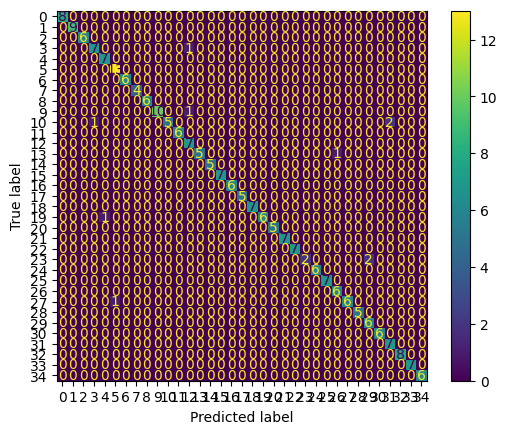

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(b, a)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
torch.save(model.state_dict(),"modelo.pth")

In [ ]:
from google.colab import files
files.download('modelo.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>